In [1]:
import os
from pathlib import Path
import xarray as xr
import xarray_sentinel
import rasterio as rio

In [2]:
os.listdir("../assets/products")

['.gitkeep',
 'S1A_IW_GRDH_1SDV_20221006T070325_20221006T070349_045318_056B02_53E7.zip',
 'S1A_IW_GRDH_1SDV_20221006T070325_20221006T070349_045318_056B02_53E7.SAFE']

### Calibrate DN to sigma-nought

In [3]:
grd_prod_path = Path('../assets/products/S1A_IW_GRDH_1SDV_20221006T070325_20221006T070349_045318_056B02_53E7.SAFE')

In [4]:
grd_iw_vv = xr.open_dataset(grd_prod_path, group="IW/VV", engine="sentinel-1")
grd_iw_vv.attrs.keys()

Warning 1: PROJ: proj_create_from_database: Cannot find proj.db


dict_keys(['family_name', 'number', 'mode', 'swaths', 'orbit_number', 'relative_orbit_number', 'pass', 'ascending_node_time', 'transmitter_receiver_polarisations', 'product_type', 'start_time', 'stop_time', 'radar_frequency', 'azimuth_pixel_spacing', 'range_pixel_spacing', 'product_first_line_utc_time', 'product_last_line_utc_time', 'azimuth_time_interval', 'image_slant_range_time', 'range_sampling_rate', 'incidence_angle_mid_swath', 'geospatial_bounds', 'geospatial_lat_min', 'geospatial_lat_max', 'geospatial_lon_min', 'geospatial_lon_max', 'group', 'subgroups', 'Conventions', 'history'])

In [5]:
# Get the calibrated data values from LUTs
grd_iw_vv_calibration = xr.open_dataset(grd_prod_path, group="IW/VV/calibration", engine="sentinel-1")
grd_iw_vv_calibration.data_vars

Data variables:
    azimuth_time  (line) datetime64[ns] ...
    sigmaNought   (line, pixel) float32 ...
    betaNought    (line, pixel) float32 ...
    gamma         (line, pixel) float32 ...
    dn            (line, pixel) float32 ...

In [6]:
# Calibrate images to NRCS sigma-nought 
calibrated = xarray_sentinel.calibrate_intensity(grd_iw_vv.measurement, grd_iw_vv_calibration.sigmaNought)

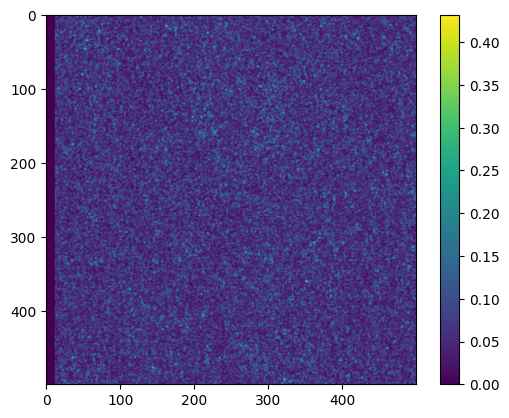

In [16]:
# Plot a piece of image with value var to simply check visually
from matplotlib import pyplot as plt
plt.imshow(calibrated[:500,:500])
plt.colorbar()

In [9]:
xr.open_dataset(grd_prod_path, group="IW/VV/gcp", engine="sentinel-1")

<xarray.Dataset>
Dimensions:           (azimuth_time: 10, slant_range_time: 21)
Coordinates:
  * azimuth_time      (azimuth_time) datetime64[ns] 2022-10-06T07:03:25.12547...
  * slant_range_time  (slant_range_time) float64 0.005334 0.005378 ... 0.006396
    line              (azimuth_time) int64 ...
    pixel             (slant_range_time) int64 ...
Data variables:
    latitude          (azimuth_time, slant_range_time) float64 ...
    longitude         (azimuth_time, slant_range_time) float64 ...
    height            (azimuth_time, slant_range_time) float64 ...
    incidenceAngle    (azimuth_time, slant_range_time) float64 ...
    elevationAngle    (azimuth_time, slant_range_time) float64 ...
Attributes: (12/22)
    family_name:                         SENTINEL-1
    number:                              A
    mode:                                IW
    swaths:                              ['IW']
    orbit_number:                        45318
    relative_orbit_number:               96
    ...                                  ...
    geospatial_lon_max:                  -15.0638147191664
    group:                               /IW/VV/gcp
    Conventions:                         CF-1.8
    title:                               Geolocation grid
    comment:                             The dataset contains geolocation gri...
    history:                             created by xarray_sentinel-0.9.3

### Write calibrated and georeferenced image

In [10]:
# Open the source raster file for metadata
src = rio.open(list(Path(grd_prod_path / 'measurement').glob('*vv*.tiff'))[0])

In [11]:
src.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 25446,
 'height': 16419,
 'count': 1,
 'crs': None,
 'transform': Affine(1.0, 0.0, 0.0,
        0.0, 1.0, 0.0)}

In [12]:
from shipdetect import __all__
__all__

['utils', '__version__']

In [13]:
from shipdetect.utils import GCPs2GeoTransform, write_tif

# Apply geotransform from GCPs
transf_from_gcps, CRS = GCPs2GeoTransform(src)

Warning 1: PROJ: proj_create_from_database: Cannot find proj.db


In [14]:
# Write calibrated georeferenced fiff file
dest = Path(grd_prod_path / 'measurement/calibrated.tiff')
write_tif(calibrated.to_numpy(), src, transf_from_gcps, CRS, dest)

saved tif: <closed DatasetWriter name='../assets/products/S1A_IW_GRDH_1SDV_20221006T070325_20221006T070349_045318_056B02_53E7.SAFE/measurement/calibrated.tiff' mode='w'>


ERROR 1: PROJ: proj_create_from_name: Cannot find proj.db
